In [2]:
%pip install stanza

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 32.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import stanza
import re

In [4]:
yelp = pd.read_csv("yelp_labelled.txt", delimiter='\t', names=['Review', 'Positive/Negative'])

In [5]:
yelp

,Review,Positive/Negative
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [12]:
yelp[yelp["Positive/Negative"] == 1].count

<bound method DataFrame.count of                                                 Review  Positive/Negative
0                             Wow... Loved this place.                  1
3    Stopped by during the late May bank holiday of...                  1
4    The selection on the menu was great and so wer...                  1
8                            The fries were great too.                  1
9                                       A great touch.                  1
..                                                 ...                ...
899                       Overall, a great experience.                  1
901  Their regular toasted bread was equally satisf...                  1
907  The chips and sals a here is amazing!!!!!!!!!!...                  1
909              This is my new fav Vegas buffet spot.                  1
922  Every time I eat here, I see caring teamwork t...                  1

[500 rows x 2 columns]>

In [13]:
senti_word = pd.read_csv("SentiWords_1.1.txt", delimiter='\t', skiprows=25)

In [14]:
senti_word

,# lemma#PoS,prior_polarity_score
0,.22_caliber#a,0.00000
1,.22_calibre#a,0.00000
2,.22-caliber#a,0.00000
3,.22-calibre#a,0.00000
4,.22#n,0.12208
...,...,...
155282,zymolytic#a,-0.19821
155283,zymosis#n,0.15754
155284,zymotic#a,-0.08847
155285,zymurgy#n,0.00000


In [15]:
senti_word.rename(columns = {'# lemma#PoS':'lemma'}, inplace = True)
senti_word["POS"] = senti_word["lemma"].str.extract(r'(#[^?]$)')
senti_word["lemma"] = senti_word["lemma"].str.extract(r'(.*#)')
senti_word["POS"] = senti_word["POS"].str.replace("#","")
senti_word["lemma"] = senti_word["lemma"].str.replace("#","")

In [16]:
senti_word

,lemma,prior_polarity_score,POS
0,.22_caliber,0.00000,a
1,.22_calibre,0.00000,a
2,.22-caliber,0.00000,a
3,.22-calibre,0.00000,a
4,.22,0.12208,n
...,...,...,...
155282,zymolytic,-0.19821,a
155283,zymosis,0.15754,n
155284,zymotic,-0.08847,a
155285,zymurgy,0.00000,n


In [20]:
set(senti_word["POS"])

{'a', 'n', 'r', 'v'}

In [23]:
senti_word[senti_word["POS"] == 'r'].count

<bound method DataFrame.count of                lemma  prior_polarity_score POS
372            a_bit               0.00000   r
376       a_cappella               0.00000   r
379       a_fortiori               0.15793   r
380      a_good_deal               0.15793   r
381     a_great_deal               0.19877   r
...              ...                   ...  ..
154815    youthfully               0.12208   r
154968     zealously               0.15793   r
155027     zestfully               0.00000   r
155029       zestily               0.00000   r
155064        zigzag               0.00000   r

[4481 rows x 3 columns]>

In [ ]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package         |
-------------------------------
| tokenize  | combined        |
| pos       | combined_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Done loading processors!


In [ ]:
lib = senti_word["lemma"].to_numpy()
pps = senti_word["prior_polarity_score"].to_numpy()

def lemma(doc):
  return [word.text.lower() for sent in doc.sentences for word in sent.words if word.upos not in ["PUNCT", "ADP"]]

def score(words):
  s = {"n": 0, "p": 0}
  for word in words:
    indeces = np.where(lib == word)
    if len(indeces) > 0:
      for i in pps[indeces]:
        if i > 0.0:
          s["p"] += i
        else:
          s["n"] += i
  return 1 if abs(s["p"]) > abs(s["n"]) else 0


In [ ]:
def new_model(yelp):
  scores_new = np.zeros(len(yelp))
  for i, review in enumerate(yelp["Review"]):
    doc = nlp(review)
    lemmas = lemma(doc)
    scores_new[i] = score(lemmas)
  return scores_new

In [ ]:
yelp_scores_pred = new_model(yelp)
yelp_scores_real = yelp["Positive/Negative"]

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

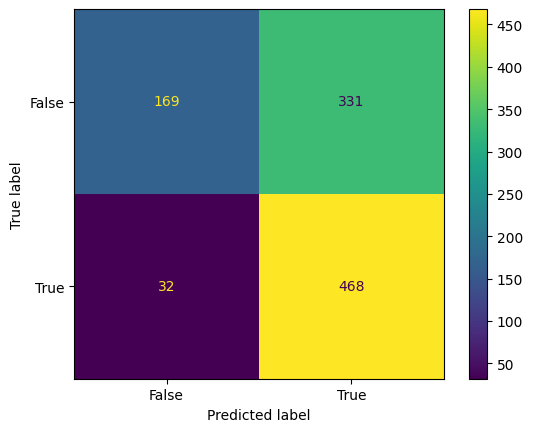

In [ ]:
confusion_matrix = metrics.confusion_matrix(yelp_scores_real, yelp_scores_pred)
f1_scores = metrics.f1_score(yelp_scores_real, yelp_scores_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
labels = [0, 1]
f1_scores = metrics.f1_score(yelp_scores_real, yelp_scores_pred, average=None, labels=labels)
f1_scores_with_labels = {label:score for label,score in zip(labels, f1_scores)}

In [ ]:
f1_scores_with_labels

{0: 0.48216833095577755, 1: 0.7205542725173211}

In [ ]:
f1_scores

0.7205542725173211

In [ ]:
def stanza_model(yelp):
  scores_new = np.zeros(len(yelp))
  for i, review in enumerate(yelp["Review"]):
    doc = nlp(review)
    for j, sentence in enumerate(doc.sentences):
      scores_new[i] = 1 if sentence.sentiment > 0 else 0
  return scores_new

In [ ]:
stanza_score = stanza_model(yelp)

In [ ]:
stanza_score

array([1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1.

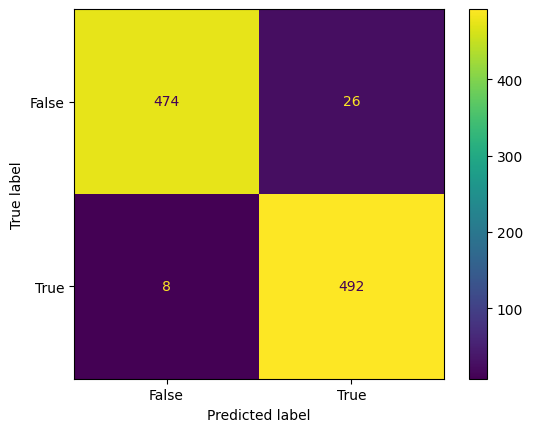

In [ ]:
confusion_matrix = metrics.confusion_matrix(yelp_scores_real, stanza_score)
f1_scores = metrics.f1_score(yelp_scores_real, stanza_score)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
labels = [0, 1]
f1_scores = metrics.f1_score(yelp_scores_real, stanza_score, average=None, labels=labels)
f1_scores_with_labels = {label:score for label,score in zip(labels, f1_scores)}

In [ ]:
f1_scores_with_labels

{0: 0.965376782077393, 1: 0.9666011787819253}

In [ ]:
f1_scores

array([0.96537678, 0.96660118])